# ddPCR SNP Assay Design

This notebook designs **dual-color hydrolysis probe assays** (e.g., TaqMan) for Droplet Digital PCR (ddPCR) to detect specific Single Nucleotide Polymorphisms (SNPs) or small indels.

## Assay Strategy
For each variant, we design a single pair of primers and two competition probes:
1.  **Common Primers**: Flank the variant site. Amplify both Wild Type (WT) and Mutant (MUT) alleles.
2.  **WT Probe (e.g., VIC/HEX)**: Specifically binds to the Reference allele sequence.
3.  **MUT Probe (e.g., FAM)**: Specifically binds to the Variant allele sequence.

## Workflow
1.  **Load Variants**: Read target variants from a VCF file.
2.  **Sequence Generation**: Extract the Reference sequence and generate the Mutant sequence in silico.
3.  **Design Primers & WT Probe**: Use `primer3` to pick optimal primers and a probe for the Reference sequence.
4.  **Design MUT Probe**: Use `primer3` to pick a compatible probe for the Mutant sequence, constrained by the chosen primers.
5.  **Virtual PCR**: Simulate PCR amplification to verify primers work on both alleles.
6.  **Export**: Save the primer and probe sequences to a CSV file ready for ordering.

In [1]:
# Install dependencies if needed
%pip install primer3-py pysam

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pysam
import primer3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import yaml

# Load Configuration
CONFIG_PATH = "../config/pipeline_config.yml"
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Extract Paths from Config
BASE_DIR = Path("../")
DATA_DIR = BASE_DIR / "data_cluster"
PATIENT_ID = config['data_source']['patient_id_filter']
GENE_NAME = config['variant_calling']['target_gene']['name']

# Construct Paths dynamically
VCF_PATH = DATA_DIR / "variants" / f"{PATIENT_ID}.lofreq.ann.vcf.gz"
REF_GENOME_PATH = DATA_DIR / "reference" / config['reference_genome']['filename']
OUTPUT_CSV = "ddpcr_snp_assays.csv"
OUTPUT_DIR = "ddpcr_design_output"

print(f"Target Patient: {PATIENT_ID}")
print(f"Target Gene: {GENE_NAME}")
print(f"VCF Path: {VCF_PATH}")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Validation
if not VCF_PATH.exists():
    print(f"Warning: VCF file not found at {VCF_PATH}")
if not REF_GENOME_PATH.exists():
    print(f"Warning: Reference genome not found at {REF_GENOME_PATH}")

In [3]:
def get_sequences(chrom, pos, ref, alt, genome_fasta, flank_size=200):
    """
    Generates Reference and Mutant sequences for a variant.
    """
    start = pos - 1 - flank_size
    end = pos - 1 + len(ref) + flank_size
    ref_seq = genome_fasta.fetch(chrom, start, end)
    
    prefix = ref_seq[:flank_size]
    suffix = ref_seq[flank_size + len(ref):]
    mut_seq = prefix + alt + suffix
    target_pos = flank_size
    return ref_seq, mut_seq, target_pos

def design_snp_assay(ref_seq, mut_seq, target_pos, ref_len, alt_len, assay_name="assay"):
    """
    Designs common primers and specific probes for WT and MUT alleles.
    """
    # --- Step 1: Design Primers & WT Probe ---
    seq_args_ref = {
        'SEQUENCE_ID': f"{assay_name}_WT",
        'SEQUENCE_TEMPLATE': ref_seq,
        'SEQUENCE_TARGET': [target_pos, ref_len]
    }
    global_args = {
        'PRIMER_TASK': 'generic',
        'PRIMER_PICK_LEFT_PRIMER': 1,
        'PRIMER_PICK_RIGHT_PRIMER': 1,
        'PRIMER_PICK_INTERNAL_OLIGO': 1,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_MIN_SIZE': 18,
        'PRIMER_MAX_SIZE': 27,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 55.0,
        'PRIMER_MAX_TM': 65.0,
        'PRIMER_MIN_GC': 20.0,
        'PRIMER_MAX_GC': 80.0,
        'PRIMER_PRODUCT_SIZE_RANGE': [[60, 120]],
        'PRIMER_INTERNAL_OPT_TM': 65.0,
        'PRIMER_INTERNAL_MIN_TM': 58.0,
        'PRIMER_INTERNAL_MAX_TM': 75.0,
        'PRIMER_NUM_RETURN': 1
    }
    try:
        # Use design_primers instead of designPrimers (deprecated)
        res_ref = primer3.bindings.design_primers(seq_args_ref, global_args)
    except Exception as e:
        print(f"  Ref design failed: {e}")
        return None
    if res_ref.get('PRIMER_PAIR_NUM_RETURNED', 0) == 0:
        print(f"  Ref design failed. Left: {res_ref.get('PRIMER_LEFT_EXPLAIN', 'N/A')}, Right: {res_ref.get('PRIMER_RIGHT_EXPLAIN', 'N/A')}, Internal: {res_ref.get('PRIMER_INTERNAL_EXPLAIN', 'N/A')}")
        return None

    fwd_primer = res_ref['PRIMER_LEFT_0_SEQUENCE']
    rev_primer = res_ref['PRIMER_RIGHT_0_SEQUENCE']
    wt_probe = res_ref['PRIMER_INTERNAL_0_SEQUENCE']
    
    # --- Step 2: Design MUT Probe ---
    seq_args_mut = {
        'SEQUENCE_ID': f"{assay_name}_MUT",
        'SEQUENCE_TEMPLATE': mut_seq,
        'SEQUENCE_TARGET': [target_pos, alt_len],
    }
    global_args_mut = global_args.copy()
    global_args_mut['PRIMER_PICK_LEFT_PRIMER'] = 0
    global_args_mut['PRIMER_PICK_RIGHT_PRIMER'] = 0
    global_args_mut['PRIMER_PICK_INTERNAL_OLIGO'] = 1
    
    try:
        res_mut = primer3.bindings.design_primers(seq_args_mut, global_args_mut)
    except Exception as e:
        print(f"  Mut design failed: {e}")
        return {
            'Forward_Primer': fwd_primer,
            'Reverse_Primer': rev_primer,
            'WT_Probe': wt_probe,
            'MUT_Probe': None,
            'Amplicon_Size': res_ref['PRIMER_PAIR_0_PRODUCT_SIZE']
        }

    mut_probe = res_mut.get('PRIMER_INTERNAL_0_SEQUENCE', None)
    return {
        'Forward_Primer': fwd_primer,
        'Reverse_Primer': rev_primer,
        'WT_Probe': wt_probe,
        'MUT_Probe': mut_probe,
        'Amplicon_Size': res_ref['PRIMER_PAIR_0_PRODUCT_SIZE']
    }

In [4]:
def simple_insilico_pcr(forward_primer, reverse_primer, template_seq):
    """
    Performs a simple in-silico PCR by searching for primer binding sites.
    Returns the amplicon sequence if found, or None.
    Handles reverse complement for the reverse primer.
    """
    import re
    
    def reverse_complement(seq):
        complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 
                      'a': 't', 'c': 'g', 'g': 'c', 't': 'a'}
        return "".join(complement.get(base, base) for base in reversed(seq))

    # Normalize sequences
    fwd = forward_primer.upper()
    rev = reverse_primer.upper()
    template = template_seq.upper()
    
    # Reverse complement the reverse primer to find its binding site on the forward strand
    rev_rc = reverse_complement(rev)
    
    # Find forward primer
    fwd_match = template.find(fwd)
    if fwd_match == -1:
        return None # Forward primer not found
        
    # Find reverse primer binding site (after forward primer)
    # We search for the reverse complement of the reverse primer
    rev_match = template.find(rev_rc, fwd_match + len(fwd))
    if rev_match == -1:
        return None # Reverse primer not found
        
    # Extract amplicon
    # The amplicon includes the forward primer and the reverse primer binding site
    # End index should be the end of the reverse primer binding site
    amplicon_end = rev_match + len(rev_rc)
    amplicon = template[fwd_match:amplicon_end]
    
    return amplicon

def visualize_ddpcr_gel(fwd_primer, rev_primer, wt_fasta_path, mut_fasta_path, assay_name, output_dir):
    """
    Simulates PCR and generates a gel image for ddPCR (Common Primers).
    Shows amplification on both WT and MUT templates.
    """
    # Read templates from FASTA files
    def read_fasta(path):
        with open(path, 'r') as f:
            lines = f.readlines()
        seq = ""
        for line in lines:
            if not line.startswith(">"):
                seq += line.strip()
        return seq

    wt_seq = read_fasta(wt_fasta_path)
    mut_seq = read_fasta(mut_fasta_path)

    reactions = [
        ("Common Primers + WT Template", fwd_primer, rev_primer, wt_seq),
        ("Common Primers + MUT Template", fwd_primer, rev_primer, mut_seq),
    ]
    
    pcr_results = {}
    print(f"Running Virtual PCR for {assay_name}...")
    
    for label, fwd, rev, template in reactions:
        try:
            amplicon = simple_insilico_pcr(fwd, rev, template)
            
            if amplicon:
                product_size = len(amplicon)
                pcr_results[label] = product_size
                print(f"  {label}: {product_size} bp")
            else:
                pcr_results[label] = None
                print(f"  {label}: No amplification")
                
        except Exception as e:
            print(f"  {label}: Error {e}")
            pcr_results[label] = None

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(4, 6))
    ax.set_facecolor("#e0e0e0")
    fig.patch.set_facecolor("#e0e0e0")
    
    # Ladder
    marker_lane_x = 1.0
    marker_sizes = [50, 100, 150, 200, 300]
    for size in marker_sizes:
        y = np.log10(size) * 2.0
        rect = patches.Rectangle((marker_lane_x - 0.15, y - 0.01), 0.3, 0.02, facecolor="black", alpha=0.9)
        ax.add_patch(rect)
        ax.text(marker_lane_x - 0.3, y, f"{size}", ha="right", va="center", fontsize=8)
    ax.text(marker_lane_x, 5.5, "Ladder", ha="center", va="bottom", fontsize=9)

    # Lanes
    lane_x_positions = [2.0, 3.0]
    for i, (label, size) in enumerate(pcr_results.items()):
        x = lane_x_positions[i]
        # Well
        ax.add_patch(patches.Rectangle((x - 0.2, 5.2), 0.4, 0.1, facecolor="#b0b0b0", edgecolor="black"))
        # Label
        short_label = "WT Temp" if "WT" in label else "MUT Temp"
        ax.text(x, 5.5, short_label, ha="center", va="bottom", fontsize=9)
        
        if size:
            y = np.log10(size) * 2.0
            ax.add_patch(patches.Rectangle((x - 0.25, y - 0.02), 0.5, 0.04, facecolor="black", alpha=0.95))
            ax.text(x, y-0.15, f"{size}bp", ha="center", va="top", fontsize=7)

    ax.set_xlim(0, 4.0)
    ax.set_ylim(3.0, 6.0)
    ax.axis('off')
    
    out_path = os.path.join(output_dir, f"{assay_name}_gel.png")
    plt.savefig(out_path, dpi=150, bbox_inches='tight', facecolor="#e0e0e0")
    plt.close()
    return out_path


Processing ../data/vcf/CTC030/CTC030_pre_treatment_KRAS.lofreq.ann.vcf.gz...

Designing for 12_25209531_G_A...
Running Virtual PCR for 12_25209531_G_A...
  Common Primers + WT Template: 117 bp
  Common Primers + MUT Template: 117 bp
  -> Success. Gel image generated.


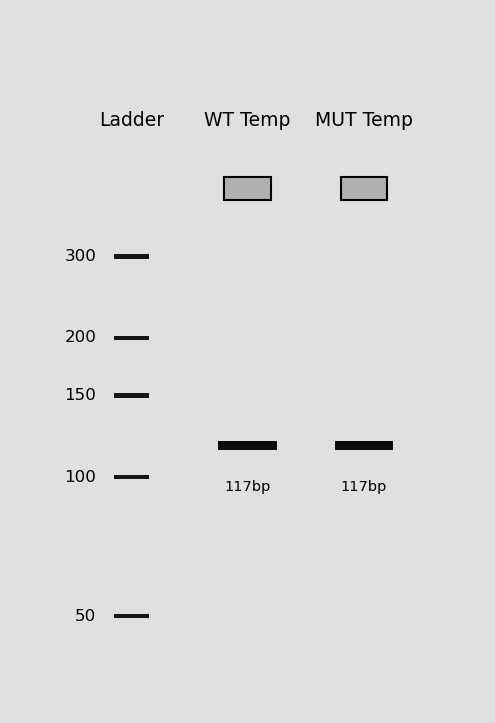


Designing for 12_25209618_A_C...
Running Virtual PCR for 12_25209618_A_C...
  Common Primers + WT Template: 118 bp
  Common Primers + MUT Template: 118 bp
  -> Success. Gel image generated.

Designing for 12_25209843_A_G...
  Ref design failed. Left: considered 1507, GC content failed 290, low tm 840, high tm 12, long poly-x seq 38, ok 327, Right: considered 1748, GC content failed 365, low tm 855, high hairpin stability 51, long poly-x seq 9, ok 468, Internal: considered 3476, GC content failed 650, low tm 2762, long poly-x seq 48, ok 16
  -> Design failed

Designing for 12_25215150_T_C...
  Ref design failed. Left: considered 1505, GC content failed 255, low tm 675, high tm 35, long poly-x seq 47, ok 493, Right: considered 1785, GC content failed 356, low tm 1310, ok 119, Internal: considered 3515, GC content failed 666, low tm 2747, long poly-x seq 47, ok 55
  -> Design failed

Designing for 12_25215659_A_AT...
Running Virtual PCR for 12_25215659_A_AT...
  Common Primers + WT Templ

,VariantID,Forward_Primer,Reverse_Primer,WT_Probe_VIC,MUT_Probe_FAM,Amplicon_Size,Gel_Image
0,12_25209531_G_A,TCACACCAACATTCACAATTGG,TGAACTAGCAATGCCTGTGA,ACTGCATGCACCAAAAGCCCCA,ACTGCATGCACCAAAAACCCCAA,117,ddpcr_design_output/12_25209531_G_A_gel.png
1,12_25209618_A_C,AGGCATTGCTAGTTCAAAAACCA,GCTCCATGCAGACTGTTAGC,ACTCTGGGAATACTGGCACTTAGAGGA,ACTGCATGCACCAAAAGCCCCA,118,ddpcr_design_output/12_25209618_A_C_gel.png
2,12_25215659_A_AT,AGTCTGTTGCATTGGTAAGAGT,TTCAAACAGTCTGATGTCTGT,ACTGGGAAAGCCATGTGCAAGAAGT,ACTGGGAAAGCCATGTGCAAGAAGT,108,ddpcr_design_output/12_25215659_A_AT_gel.png
3,12_25215659_AT_A,AGTCTGTTGCATTGGTAAGAGT,TTCAAACAGTCTGATGTCTGT,ACTGGGAAAGCCATGTGCAAGAAGT,ACTGGGAAAGCCATGTGCAAGAAGT,108,ddpcr_design_output/12_25215659_AT_A_gel.png
4,12_25227505_TA_T,GGTGTTATATACAACTCAACAACA,TTTCAGGTGCTTAGTGGCCA,TGTTCCTGCTCCAAAGATGACGGACA,ACGGACAAATGGCCACTAAGCACC,114,ddpcr_design_output/12_25227505_TA_T_gel.png


In [5]:
# Main Execution
results = []

if os.path.exists(VCF_PATH) and os.path.exists(REF_GENOME_PATH):
    vcf_in = pysam.VariantFile(VCF_PATH)
    genome = pysam.FastaFile(REF_GENOME_PATH)
    
    print(f"Processing {VCF_PATH}...")
    
    for rec in vcf_in.fetch():
        chrom = rec.chrom
        pos = rec.pos
        ref = rec.ref
        alt = rec.alts[0] if rec.alts else None
        if not alt: continue
            
        variant_id = f"{chrom}_{pos}_{ref}_{alt}"
        print(f"\nDesigning for {variant_id}...")
        
        # 1. Get Sequences
        ref_seq, mut_seq, target_pos = get_sequences(chrom, pos, ref, alt, genome)
        
        # 2. Design Assay
        assay = design_snp_assay(ref_seq, mut_seq, target_pos, len(ref), len(alt), assay_name=variant_id)
        
        if assay:
            # 3. Virtual PCR & Visualization
            # Save temp FASTA for InSilicoPCR
            wt_fasta = os.path.join(OUTPUT_DIR, f"{variant_id}_WT.fasta")
            mut_fasta = os.path.join(OUTPUT_DIR, f"{variant_id}_MUT.fasta")
            with open(wt_fasta, 'w') as f: f.write(f">WT\n{ref_seq}\n")
            with open(mut_fasta, 'w') as f: f.write(f">MUT\n{mut_seq}\n")
            
            gel_img = visualize_ddpcr_gel(
                assay['Forward_Primer'], assay['Reverse_Primer'], 
                wt_fasta, mut_fasta, variant_id, OUTPUT_DIR
            )
            
            row = {
                'VariantID': variant_id,
                'Forward_Primer': assay['Forward_Primer'],
                'Reverse_Primer': assay['Reverse_Primer'],
                'WT_Probe_VIC': assay['WT_Probe'],
                'MUT_Probe_FAM': assay['MUT_Probe'],
                'Amplicon_Size': assay['Amplicon_Size'],
                'Gel_Image': gel_img
            }
            results.append(row)
            print("  -> Success. Gel image generated.")
            
            # Display the first gel image in notebook
            if len(results) == 1:
                from IPython.display import Image, display
                display(Image(filename=gel_img))
        else:
            print("  -> Design failed")
            
    vcf_in.close()
    genome.close()
    
    if results:
        df = pd.DataFrame(results)
        df.to_csv(OUTPUT_CSV, index=False)
        print(f"\nSaved {len(df)} assays to {OUTPUT_CSV}")
        from IPython.display import display
        display(df)
    else:
        print("No assays generated.")
else:
    print("Input files missing.")